Total epochs logged: 1500


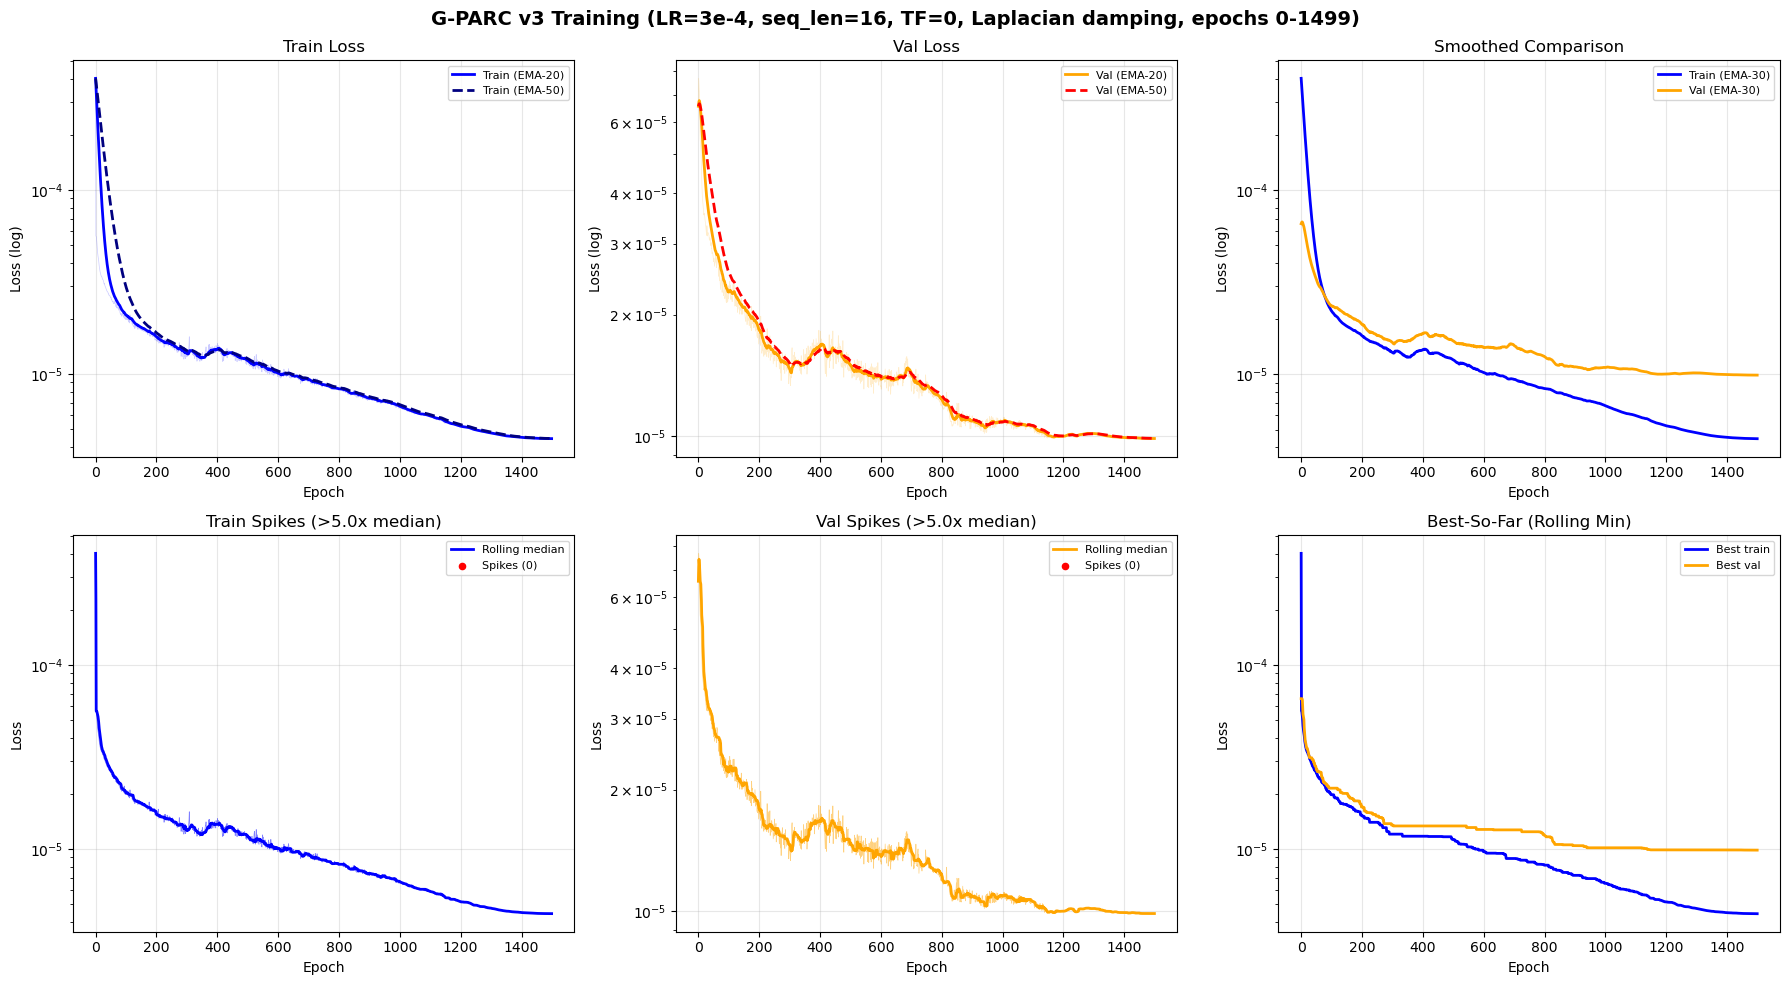

✅ Saved: v3_loss_analysis.png

G-PARC v3 TRAINING STATUS
  Current epoch: 1499
  Train loss:    4.45e-06
  Val loss:      9.87e-06
  Best val:      9.86e-06 (epoch 1494)
  Train spikes:  0/1500 epochs
  Val spikes:    0/1500 epochs

  Val loss improving? SLOWLY (0.3% over last 50 epochs)


In [3]:
#!/usr/bin/env python3
"""
Training Diagnostics for G-PARC v3 (Laplacian Damping)
- Smoothed loss curves to see trends through noise
- Spike detection and analysis
- Rolling statistics
"""
import matplotlib.pyplot as plt
import json
import numpy as np
from pathlib import Path

# ============================================================
# LOAD DATA
# ============================================================
history_path = '/scratch/jtb3sud/elasto_meshgraphkan/run1/training_history.json'
with open(history_path) as f:
    hist = json.load(f)

train_loss = np.array(hist['train_loss'])
val_loss = np.array(hist['val_loss'])
epochs = np.arange(len(train_loss))
max_disp = 542.1
epochs = np.arange(len(train_loss))
print(f"Total epochs logged: {len(train_loss)}")

# ============================================================
# SMOOTHING HELPER
# ============================================================
def smooth(y, window=20):
    """Exponential moving average."""
    alpha = 2 / (window + 1)
    result = np.zeros_like(y)
    result[0] = y[0]
    for i in range(1, len(y)):
        result[i] = alpha * y[i] + (1 - alpha) * result[i-1]
    return result

# ============================================================
# FIGURE: LOSS CURVES
# ============================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1a. Raw + smoothed train loss
ax = axes[0, 0]
ax.plot(epochs, train_loss, alpha=0.2, color='blue', linewidth=0.5)
ax.plot(epochs, smooth(train_loss, 20), color='blue', linewidth=2, label='Train (EMA-20)')
ax.plot(epochs, smooth(train_loss, 50), color='navy', linewidth=2, linestyle='--', label='Train (EMA-50)')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (log)')
ax.set_title('Train Loss')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# 1b. Raw + smoothed val loss
ax = axes[0, 1]
ax.plot(epochs, val_loss, alpha=0.2, color='orange', linewidth=0.5)
ax.plot(epochs, smooth(val_loss, 20), color='orange', linewidth=2, label='Val (EMA-20)')
ax.plot(epochs, smooth(val_loss, 50), color='red', linewidth=2, linestyle='--', label='Val (EMA-50)')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (log)')
ax.set_title('Val Loss')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# 1c. Both smoothed on same axes
ax = axes[0, 2]
ax.plot(epochs, smooth(train_loss, 30), color='blue', linewidth=2, label='Train (EMA-30)')
ax.plot(epochs, smooth(val_loss, 30), color='orange', linewidth=2, label='Val (EMA-30)')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (log)')
ax.set_title('Smoothed Comparison')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# 2a. Spike analysis - train
ax = axes[1, 0]
window = 10
rolling_median_train = np.array([np.median(train_loss[max(0,i-window):i+1]) for i in range(len(train_loss))])
spike_threshold = 5.0
train_spikes = train_loss > (rolling_median_train * spike_threshold)
ax.plot(epochs, train_loss, alpha=0.5, color='blue', linewidth=0.5)
ax.plot(epochs, rolling_median_train, color='blue', linewidth=2, label='Rolling median')
ax.scatter(epochs[train_spikes], train_loss[train_spikes], color='red', s=20, zorder=5, label=f'Spikes ({train_spikes.sum()})')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Train Spikes (>{spike_threshold}x median)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# 2b. Spike analysis - val
ax = axes[1, 1]
rolling_median_val = np.array([np.median(val_loss[max(0,i-window):i+1]) for i in range(len(val_loss))])
val_spikes = val_loss > (rolling_median_val * spike_threshold)
ax.plot(epochs, val_loss, alpha=0.5, color='orange', linewidth=0.5)
ax.plot(epochs, rolling_median_val, color='orange', linewidth=2, label='Rolling median')
ax.scatter(epochs[val_spikes], val_loss[val_spikes], color='red', s=20, zorder=5, label=f'Spikes ({val_spikes.sum()})')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Val Spikes (>{spike_threshold}x median)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# 2c. Rolling min (best-so-far trajectory)
ax = axes[1, 2]
rolling_min_train = np.minimum.accumulate(train_loss)
rolling_min_val = np.minimum.accumulate(val_loss)
ax.plot(epochs, rolling_min_train, color='blue', linewidth=2, label='Best train')
ax.plot(epochs, rolling_min_val, color='orange', linewidth=2, label='Best val')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Best-So-Far (Rolling Min)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.suptitle(f'G-PARC v3 Training (LR=3e-4, seq_len=16, TF=0, Laplacian damping, epochs 0-{epochs[-1]})',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
plt.savefig('v3_loss_analysis.png', dpi=150, bbox_inches='tight')
plt.close()
print("✅ Saved: v3_loss_analysis.png")

# ============================================================
# CONSOLE SUMMARY
# ============================================================
final_train = train_loss[-1]
final_val = val_loss[-1]
best_val = val_loss.min()
best_val_epoch = epochs[val_loss.argmin()]

print(f"\n{'='*60}")
print("G-PARC v3 TRAINING STATUS")
print(f"{'='*60}")
print(f"  Current epoch: {epochs[-1]}")
print(f"  Train loss:    {final_train:.2e}")
print(f"  Val loss:      {final_val:.2e}")
print(f"  Best val:      {best_val:.2e} (epoch {best_val_epoch})")
print(f"  Train spikes:  {train_spikes.sum()}/{len(train_loss)} epochs")
print(f"  Val spikes:    {val_spikes.sum()}/{len(val_loss)} epochs")
print(f"\n  Val loss improving? ", end="")
ema50 = smooth(val_loss, 50)
if len(ema50) > 50:
    recent_trend = ema50[-1] / ema50[-50]
    if recent_trend < 0.9:
        print(f"YES (EMA-50 dropped {(1-recent_trend)*100:.1f}% over last 50 epochs)")
    elif recent_trend < 1.0:
        print(f"SLOWLY ({(1-recent_trend)*100:.1f}% over last 50 epochs)")
    else:
        print(f"PLATEAU/RISING ({(recent_trend-1)*100:.1f}% increase over last 50 epochs)")
else:
    print("Not enough data yet")
print(f"{'='*60}")

Loading G-PARC v3 (Baseline)...
Loading 2hop...
✅ Saved: comparison_analysis.png


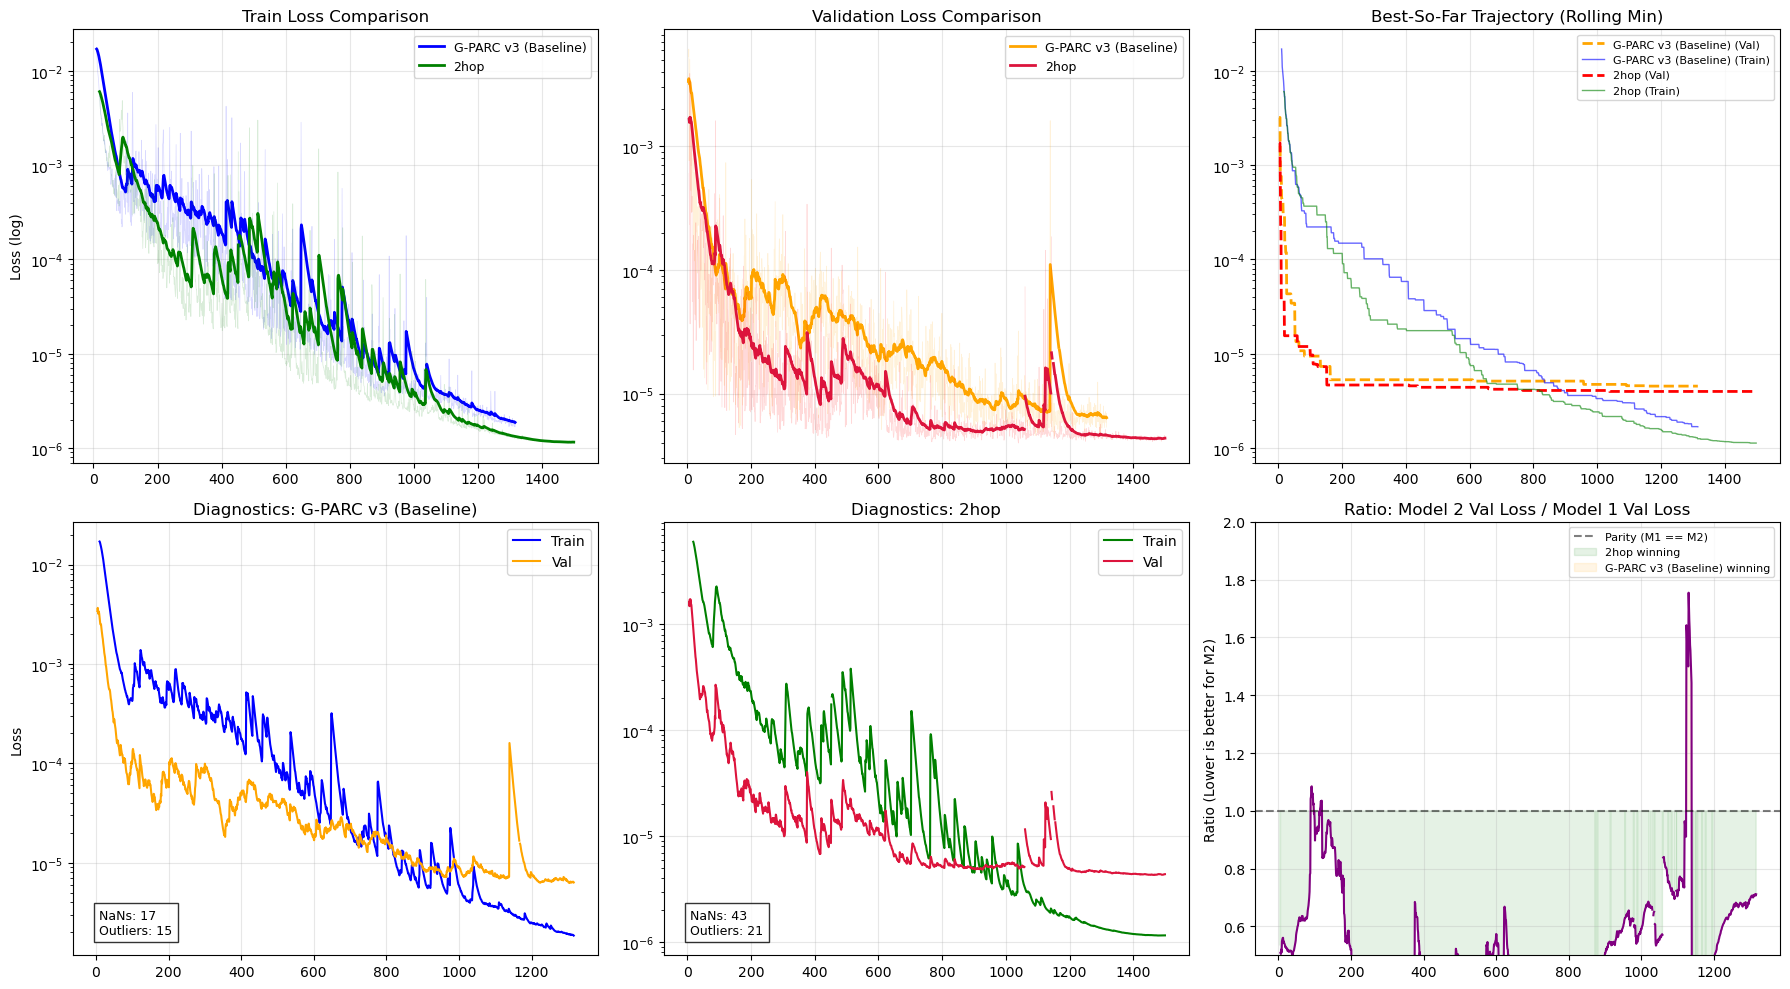

In [7]:
#!/usr/bin/env python3
"""
Comparative Training Diagnostics: Model 1 vs Model 2
- Overlays two training histories for direct comparison
- Consistent smoothing and outlier filtering across both
- NaN-safe
"""
import matplotlib.pyplot as plt
import json
import numpy as np
from pathlib import Path

# ============================================================
# CONFIGURATION
# ============================================================
# Path to Model 1 (Baseline)
model1_path = '/scratch/jtb3sud/elasto_graphconv_V2/global_max_v3_lapdamp/training_history.json'
model1_name = "G-PARC v3 (Baseline)"

# Path to Model 2 (New Experiment) - UPDATE THIS PATH
model2_path = '/scratch/jtb3sud/elasto_graphconv_V2/2hop/training_history_STITCHED_FULL.json' 
model2_name = "2hop"

SKIP_EPOCHS = 0     # Skip early training instability
OUTLIER_FACTOR = 1000  # Filter spikes > 1000x median

# ============================================================
# DATA PROCESSING HELPER
# ============================================================
def load_and_process_history(path, skip=0, outlier_thresh=1000):
    """
    Loads JSON history, handles NaNs, filters outliers, and returns 
    clean arrays for plotting.
    """
    path_obj = Path(path)
    if not path_obj.exists():
        print(f"⚠️ Warning: File not found: {path}")
        return None

    with open(path) as f:
        hist = json.load(f)

    # Convert to numpy and force None -> NaN
    t_raw = np.array([x if x is not None else np.nan for x in hist['train_loss']], dtype=np.float64)
    v_raw = np.array([x if x is not None else np.nan for x in hist['val_loss']], dtype=np.float64)

    # Mark inf as NaN
    t_raw[~np.isfinite(t_raw)] = np.nan
    v_raw[~np.isfinite(v_raw)] = np.nan

    # Filter extreme outliers
    t_med = np.nanmedian(t_raw)
    v_med = np.nanmedian(v_raw)
    
    t_outliers = t_raw > t_med * outlier_thresh
    v_outliers = v_raw > v_med * outlier_thresh
    
    t_raw[t_outliers] = np.nan
    v_raw[v_outliers] = np.nan

    # Slice
    t_final = t_raw[skip:]
    v_final = v_raw[skip:]
    epochs = np.arange(skip, skip + len(t_final))
    
    stats = {
        'n_nan': np.sum(np.isnan(t_final)) + np.sum(np.isnan(v_final)),
        'n_outliers': t_outliers[skip:].sum() + v_outliers[skip:].sum(),
        'len': len(t_final)
    }
    
    return {
        'epochs': epochs,
        'train': t_final,
        'val': v_final,
        'stats': stats
    }

# ============================================================
# LOAD DATA
# ============================================================
print(f"Loading {model1_name}...")
m1 = load_and_process_history(model1_path, SKIP_EPOCHS, OUTLIER_FACTOR)

print(f"Loading {model2_name}...")
m2 = load_and_process_history(model2_path, SKIP_EPOCHS, OUTLIER_FACTOR)

if m1 is None:
    raise FileNotFoundError("Model 1 file missing.")

# ============================================================
# SMOOTHING HELPERS
# ============================================================
def smooth(y, window=20):
    """EMA that skips NaN values."""
    if y is None or len(y) == 0: return y
    alpha = 2 / (window + 1)
    result = np.full_like(y, np.nan)
    last_valid = np.nan
    for i in range(len(y)):
        if np.isfinite(y[i]):
            if np.isnan(last_valid):
                last_valid = y[i]
            else:
                last_valid = alpha * y[i] + (1 - alpha) * last_valid
            result[i] = last_valid
    return result

def nan_rolling_min(y):
    """Cumulative min that skips NaN."""
    if y is None or len(y) == 0: return y
    result = np.full_like(y, np.nan)
    best = np.inf
    for i in range(len(y)):
        if np.isfinite(y[i]):
            best = min(best, y[i])
            result[i] = best
        elif np.isfinite(best):
            result[i] = best
    return result

# ============================================================
# FIGURE: COMPARISON
# ============================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# --- 1. TRAIN LOSS COMPARISON ---
ax = axes[0, 0]
# Model 1
ax.plot(m1['epochs'], m1['train'], alpha=0.15, color='blue', linewidth=0.5)
ax.plot(m1['epochs'], smooth(m1['train'], 30), color='blue', linewidth=2, label=f'{model1_name}')
# Model 2
if m2:
    ax.plot(m2['epochs'], m2['train'], alpha=0.15, color='green', linewidth=0.5)
    ax.plot(m2['epochs'], smooth(m2['train'], 30), color='green', linewidth=2, label=f'{model2_name}')

ax.set_yscale('log')
ax.set_title('Train Loss Comparison')
ax.set_ylabel('Loss (log)')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# --- 2. VAL LOSS COMPARISON ---
ax = axes[0, 1]
# Model 1
ax.plot(m1['epochs'], m1['val'], alpha=0.15, color='orange', linewidth=0.5)
ax.plot(m1['epochs'], smooth(m1['val'], 30), color='orange', linewidth=2, label=f'{model1_name}')
# Model 2
if m2:
    ax.plot(m2['epochs'], m2['val'], alpha=0.15, color='red', linewidth=0.5)
    ax.plot(m2['epochs'], smooth(m2['val'], 30), color='crimson', linewidth=2, label=f'{model2_name}')

ax.set_yscale('log')
ax.set_title('Validation Loss Comparison')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# --- 3. ROLLING MIN (BEST SO FAR) ---
ax = axes[0, 2]
# Model 1
ax.plot(m1['epochs'], nan_rolling_min(m1['val']), color='orange', linewidth=2, linestyle='--', label=f'{model1_name} (Val)')
ax.plot(m1['epochs'], nan_rolling_min(m1['train']), color='blue', linewidth=1, alpha=0.6, label=f'{model1_name} (Train)')
# Model 2
if m2:
    ax.plot(m2['epochs'], nan_rolling_min(m2['val']), color='red', linewidth=2, linestyle='--', label=f'{model2_name} (Val)')
    ax.plot(m2['epochs'], nan_rolling_min(m2['train']), color='green', linewidth=1, alpha=0.6, label=f'{model2_name} (Train)')

ax.set_yscale('log')
ax.set_title('Best-So-Far Trajectory (Rolling Min)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# --- 4. DIAGNOSTICS: MODEL 1 (Train vs Val) ---
ax = axes[1, 0]
ax.plot(m1['epochs'], smooth(m1['train'], 20), color='blue', label='Train')
ax.plot(m1['epochs'], smooth(m1['val'], 20), color='orange', label='Val')
ax.set_yscale('log')
ax.set_title(f'Diagnostics: {model1_name}')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)
ax.text(0.05, 0.05, f"NaNs: {m1['stats']['n_nan']}\nOutliers: {m1['stats']['n_outliers']}", 
        transform=ax.transAxes, fontsize=9, bbox=dict(facecolor='white', alpha=0.8))

# --- 5. DIAGNOSTICS: MODEL 2 (Train vs Val) ---
ax = axes[1, 1]
if m2:
    ax.plot(m2['epochs'], smooth(m2['train'], 20), color='green', label='Train')
    ax.plot(m2['epochs'], smooth(m2['val'], 20), color='crimson', label='Val')
    ax.set_yscale('log')
    ax.set_title(f'Diagnostics: {model2_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.text(0.05, 0.05, f"NaNs: {m2['stats']['n_nan']}\nOutliers: {m2['stats']['n_outliers']}", 
            transform=ax.transAxes, fontsize=9, bbox=dict(facecolor='white', alpha=0.8))
else:
    ax.text(0.5, 0.5, "Model 2 Not Found", ha='center')

# --- 6. RELATIVE PERFORMANCE (Ratio) ---
ax = axes[1, 2]
if m2:
    # Interpolate to match lengths if needed, or just slice to min length
    min_len = min(len(m1['val']), len(m2['val']))
    # Calculate ratio of smoothed losses (M2 / M1)
    # < 1.0 means M2 is better, > 1.0 means M1 is better
    s1 = smooth(m1['val'][:min_len], 50)
    s2 = smooth(m2['val'][:min_len], 50)
    
    ratio = s2 / s1
    shared_epochs = m1['epochs'][:min_len]
    
    ax.plot(shared_epochs, ratio, color='purple', linewidth=1.5)
    ax.axhline(1.0, color='black', linestyle='--', alpha=0.5, label='Parity (M1 == M2)')
    ax.fill_between(shared_epochs, ratio, 1.0, where=(ratio < 1.0), color='green', alpha=0.1, label=f'{model2_name} winning')
    ax.fill_between(shared_epochs, ratio, 1.0, where=(ratio > 1.0), color='orange', alpha=0.1, label=f'{model1_name} winning')
    
    ax.set_title('Ratio: Model 2 Val Loss / Model 1 Val Loss')
    ax.set_ylabel('Ratio (Lower is better for M2)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    # Limit y-axis to avoid massive spikes distorting view
    ax.set_ylim(0.5, 2.0) 

plt.tight_layout()
plt.savefig('comparison_analysis.png', dpi=150)
print("✅ Saved: comparison_analysis.png")
plt.show()